<a href="https://colab.research.google.com/github/kgpgaurav/Music_genre/blob/main/mfcc_mel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
#define your folder structure
data_dir = "/content/drive/MyDrive/Train"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']#classes should be in order of folders,
#such that we give correct labels to correct data


In [ ]:
import os
import numpy as np
import librosa
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical

# Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(150,150)):
    data = []
    labels = []

    # Check if all class directories exist
    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"⚠️ Warning: Directory {class_dir} does not exist! Skipping...")
            continue

        print(f"Processing-- {class_name} (Label {i_class})")
        file_count = 0  # To check if the class has valid files

        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_count += 1
                file_path = os.path.join(class_dir, filename)

                # Load audio file
                audio_data, sample_rate = librosa.load(file_path, sr=None)

                # Define chunk and overlap durations
                chunk_duration = 4
                overlap_duration = 2
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                # Calculate number of chunks
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
                if num_chunks <= 0:
                    print(f"⚠️ Skipping {filename} (too short for chunking)")
                    continue

                # Process chunks
                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    chunk = audio_data[start:end]

                    # Extract features
                    mfcc = librosa.feature.mfcc(y=chunk, sr=sample_rate, n_mfcc=40)
                    mfcc = librosa.util.normalize(mfcc)
                    mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sample_rate, n_mels=128, fmax=8000)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                    mel_spec_db = librosa.util.normalize(mel_spec_db)

                    # Resize and stack features
                    mfcc_resized = resize(np.expand_dims(mfcc, axis=-1), target_shape)
                    mel_spec_resized = resize(np.expand_dims(mel_spec_db, axis=-1), target_shape)
                    combined_features = np.concatenate((mfcc_resized, mel_spec_resized), axis=-1)

                    data.append(combined_features)
                    labels.append(i_class)

        if file_count == 0:
            print(f"⚠️ Warning: No valid WAV files found in {class_dir}")

    # Convert to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    # Check unique labels before one-hot encoding
    unique_labels = np.unique(labels)
    print(f"✅ Unique labels found: {unique_labels} (Expected: {len(classes)})")

    if len(unique_labels) < len(classes):
        print("⚠️ Some classes might be missing from the dataset!")

    # One-hot encode labels
    labels = to_categorical(labels, num_classes=len(classes))

    return data, labels

# Run the function
data, labels = load_and_preprocess_data(data_dir, classes)


Processing-- blues (Label 0)
Processing-- classical (Label 1)
Processing-- country (Label 2)
Processing-- disco (Label 3)
Processing-- hiphop (Label 4)
Processing-- jazz (Label 5)
Processing-- metal (Label 6)
Processing-- pop (Label 7)
Processing-- reggae (Label 8)
Processing-- rock (Label 9)
✅ Unique labels found: [0 1 2 3 4 5 6 7 8 9] (Expected: 10)


In [ ]:
# data,labels = load_and_preprocess_data(data_dir,classes)

In [ ]:
# from tensorflow.keras.utils import to_categorical
# labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
# labels

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [ ]:
Y_test.shape

(2396, 10)

In [ ]:
num_classes = len(np.unique(Y_test))
print("Number of unique classes in Y_test:", num_classes)

Number of unique classes in Y_test: 2


In [ ]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([4, 9, 8, ..., 4, 0, 0])

In [ ]:
num_unique = len(np.unique(true_categories))
num_unique

10

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input

# Define model
model = Sequential()

# Explicitly define input layer
model.add(Input(shape=(150, 150, 2)))  # 2 channels (MFCC & Mel)

# First convolutional layer (No need to pass input_shape in Conv2D)
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Rest of the CNN layers (no changes needed)
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=5000, activation='relu'))
model.add(Dropout(0.45))

# Output layer
model.add(Dense(units=len(classes), activation='softmax'))

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5000)                │      10,245,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          50,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,006,946 (57.25 MB)

 Trainable params: 15,006,946 (57.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input, BatchNormalization, Activation

# # Define model
# model = Sequential()

# # Explicitly define input layer
# model.add(Input(shape=(150, 150, 2)))  # 2 channels (MFCC & Mel)

# # # First convolutional layer (No need to pass input_shape in Conv2D)
# # model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
# # model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
# # model.add(MaxPool2D(pool_size=2, strides=2))

# # # Rest of the CNN layers (no changes needed)
# # model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
# # model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
# # model.add(MaxPool2D(pool_size=2, strides=2))

# # model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
# # model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
# # model.add(MaxPool2D(pool_size=2, strides=2))

# # model.add(Dropout(0.3))

# # model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
# # model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
# # model.add(MaxPool2D(pool_size=2, strides=2))

# # model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
# # model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
# # model.add(MaxPool2D(pool_size=2, strides=2))

# # model.add(Dropout(0.3))
# # model.add(Flatten())
# # model.add(Dense(units=3000, activation='relu'))
# # model.add(Dropout(0.45))

# # # Output layer
# # model.add(Dense(units=len(classes), activation='softmax'))

# # First convolutional layer
# model.add(Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(filters=32, kernel_size=3, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=2, strides=2))

# # Rest of the CNN layers with BatchNorm
# model.add(Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(filters=64, kernel_size=3, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=2, strides=2))

# model.add(Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(filters=128, kernel_size=3, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=2, strides=2))

# model.add(Dropout(0.4))

# model.add(Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(filters=256, kernel_size=3, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=2, strides=2))

# model.add(Conv2D(filters=512, kernel_size=3, padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(filters=512, kernel_size=3, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=2, strides=2))

# model.add(Dropout(0.4))
# model.add(Flatten())

# # Fully Connected Layer with BatchNorm
# model.add(Dense(units=3000, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# # Output layer
# model.add(Dense(units=len(classes), activation='softmax'))

# # Print model summary
# model.summary()


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9583, 150, 150, 2)
(2396, 150, 150, 2)
(2396, 10)


In [ ]:
# true_categories = np.argmax(Y_test,axis=1)
# true_categories

In [ ]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=20,batch_size=16,validation_data=(X_test,Y_test))

Epoch 1/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 54s 67ms/step - accuracy: 0.1860 - loss: 2.1332 - val_accuracy: 0.4808 - val_loss: 1.4068
Epoch 2/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.4870 - loss: 1.3830 - val_accuracy: 0.5438 - val_loss: 1.2500
Epoch 3/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.5834 - loss: 1.1857 - val_accuracy: 0.6361 - val_loss: 1.0318
Epoch 4/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.6570 - loss: 0.9796 - val_accuracy: 0.7008 - val_loss: 0.8922
Epoch 5/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.7280 - loss: 0.8014 - val_accuracy: 0.7295 - val_loss: 0.7968
Epoch 6/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.7651 - loss: 0.6832 - val_accuracy: 0.7099 - val_loss: 0.8484
Epoch 7/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8063 - loss: 0.5632 - val_accuracy: 0.7579 - val_loss: 0.7305
Epoch 8/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.8361 - loss: 0.4871 - 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8963 - loss: 0.3571
Test Accuracy: 89.23%
Test Loss: 38.98%


In [ ]:
X_test.shape

(2396, 150, 150, 2)

In [ ]:
y_pred = model.predict(X_test)
y_pred



75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


array([[2.1159104e-11, 3.1609411e-18, 5.6409344e-10, ..., 3.5835110e-10,
        5.3490433e-12, 2.2900046e-08],
       [2.9264809e-06, 9.3664327e-14, 4.1283527e-10, ..., 3.1327488e-12,
        3.8784506e-10, 9.9935812e-01],
       [3.0022625e-12, 3.3019095e-12, 2.1141092e-08, ..., 4.6748312e-09,
        9.8955256e-01, 2.4381286e-08],
       ...,
       [1.7618919e-02, 3.8166570e-05, 3.6225125e-02, ..., 4.7483221e-01,
        1.0545037e-02, 4.8440732e-02],
       [1.0000000e+00, 2.6032374e-24, 7.3304078e-15, ..., 3.8486222e-19,
        3.8983673e-22, 1.9615449e-12],
       [9.9924207e-01, 5.7628413e-09, 4.3842455e-04, ..., 2.3073083e-07,
        4.4506464e-06, 2.7953327e-04]], dtype=float32)

In [ ]:
y_pred.shape

(2396, 10)

In [ ]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([4, 9, 8, ..., 7, 0, 0])

In [ ]:
Y_test.shape

(2396, 10)

In [ ]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([4, 9, 8, ..., 4, 0, 0])

In [ ]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
# print(classification_report(true_categories,predicted_categories,target_names=classes))


# Find unique class labels from true_categories
unique_labels = [str(label) for label in sorted(set(true_categories))]  # Ensure labels are strings  # Get unique labels in sorted order

# Generate the classification report with correct labels
print(classification_report(true_categories, predicted_categories, target_names=unique_labels))


              precision    recall  f1-score   support

           0       0.94      0.93      0.93       245
           1       0.97      0.96      0.97       237
           2       0.93      0.79      0.86       235
           3       0.88      0.79      0.83       237
           4       0.89      0.93      0.91       254
           5       0.96      0.92      0.94       233
           6       0.85      0.99      0.91       238
           7       0.85      0.96      0.90       235
           8       0.89      0.83      0.86       242
           9       0.79      0.83      0.81       240

    accuracy                           0.89      2396
   macro avg       0.90      0.89      0.89      2396
weighted avg       0.89      0.89      0.89      2396



In [ ]:
cm

array([[227,   0,   4,   1,   0,   1,   6,   0,   1,   5],
       [  0, 228,   0,   0,   0,   4,   0,   1,   0,   4],
       [  5,   2, 186,   9,   3,   2,   4,   1,  15,   8],
       [  3,   1,   1, 187,   4,   1,  10,  13,   2,  15],
       [  0,   0,   1,   2, 235,   0,   4,  10,   2,   0],
       [  1,   1,   3,   0,   0, 214,   0,   2,   4,   8],
       [  0,   0,   0,   0,   1,   0, 235,   0,   0,   2],
       [  0,   0,   0,   1,   6,   0,   0, 225,   0,   3],
       [  2,   1,   3,   7,  12,   0,   2,   5, 202,   8],
       [  3,   1,   2,   5,   4,   2,  16,   7,   1, 199]])

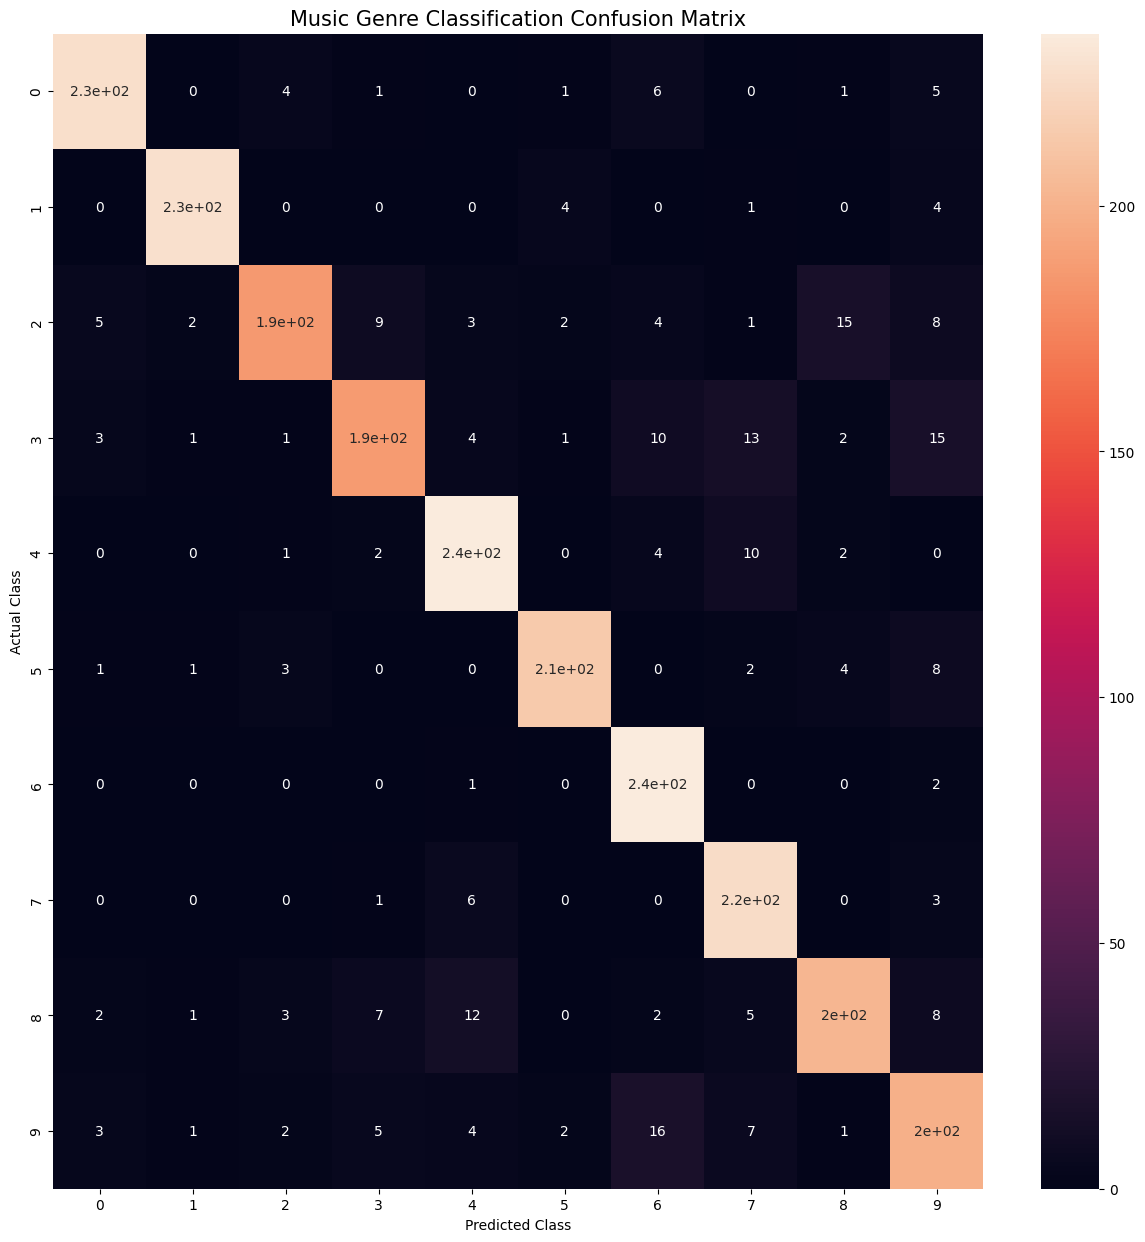

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/mfcc_mel/myModel_mfcc_mel_26_3.h5')



In [ ]:
import json

history_dict = training_history.history  # Convert history object to a dictionary
history_json_path = "/content/drive/My Drive/mfcc_mel/training_history26_3.json"  # Change path if needed

with open(history_json_path, 'w') as f:
    json.dump(history_dict, f)


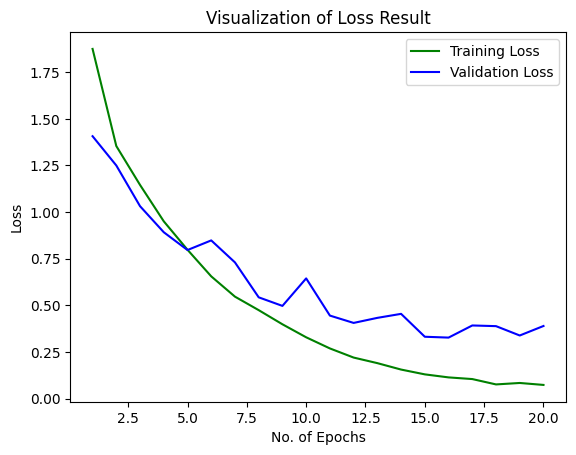

In [ ]:
#Visualization of Loss
epochs = [i for i in range(1,21)]
plt.plot(epochs,training_history.history['loss'],label="Training Loss",color='green')
plt.plot(epochs,training_history.history['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

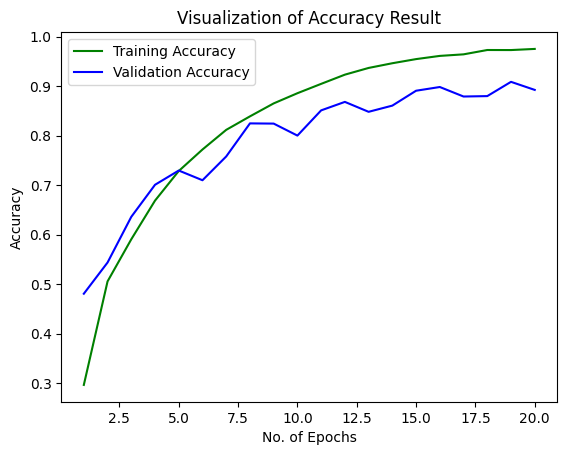

In [ ]:
#Visualization of Accuracy
epochs = [i for i in range(1,21)]
plt.plot(epochs,training_history.history['accuracy'],label="Training Accuracy",color='green')
plt.plot(epochs,training_history.history['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()